Munkhtsetseg Munkh-Orgil (Data Science)
Seasonal Price Fluctuations, Geographical Price Variations, and Forecasts of Future Prices of Food in Mongolia

In [213]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

This first section will show the seasonal fluctuations of Meat (beef) using Seasonal Decomposition of Time Series (STL) method.

In [214]:
#loading the dataset
file_path = 'wfp_food_prices_mng.csv'
data = pd.read_csv(file_path).drop(index=0)
data['date'] = pd.to_datetime(data['date'])
data[['price', 'usdprice']] = data[['price', 'usdprice']].apply(pd.to_numeric)

In [215]:
#filter the dataset for 'Meat (beef)'
beef_data = data[data['commodity'] == 'Meat (beef)']

In [216]:
#aggregates the prices by date (grouby)
beef_prices = beef_data.groupby('date')['usdprice'].mean()

In [217]:
#resample the data to have monthly intervals
beef_prices = beef_prices.resample('M').mean().interpolate()

In [218]:
#seasonal decomposition
decomposition = seasonal_decompose(beef_prices, model='additive')

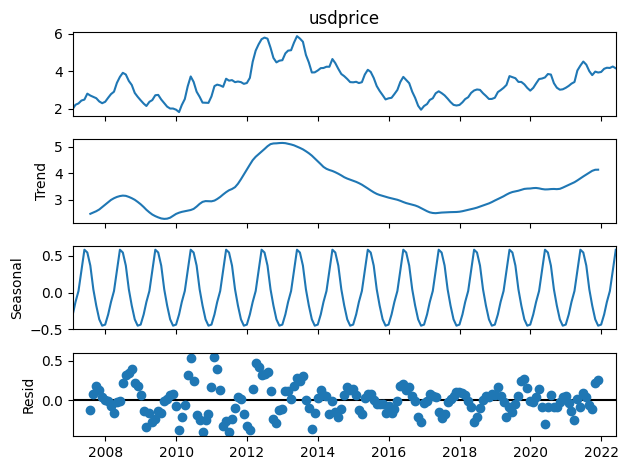

In [219]:
#plot the decomposed time series components
decomposed_components = decomposition.plot()
plt.show()

The second section will analyze the geographical price variations via clustering

In [220]:
#reload the dataset
data = pd.read_csv(file_path).drop(index=0)
data['date'] = pd.to_datetime(data['date'])
data[['latitude', 'longitude', 'price', 'usdprice']] = data[['latitude', 'longitude', 'price', 'usdprice']].apply(pd.to_numeric)

In [221]:
#average the prices based on latitude and longitude
geo_price_data = data.groupby(['latitude', 'longitude'])['usdprice'].mean().reset_index()

In [222]:
#see the first few rows of the data
geo_price_data.head()

,latitude,longitude,usdprice
0,46.27,102.78,1.953720
1,47.92,106.92,1.852149
2,48.08,114.54,1.928651
3,48.97,89.97,1.722257
4,50.24,106.21,1.818325


In [223]:
from sklearn.cluster import KMeans
import numpy as np

In [224]:
#create a cap off for max number of clusters (should not be more than data points)
#elbow method to find best number of clusters to use
distortions = []
K = range(1, max_clusters)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(geo_price_data)
    distortions.append(kmeanModel.inertia_)

/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init

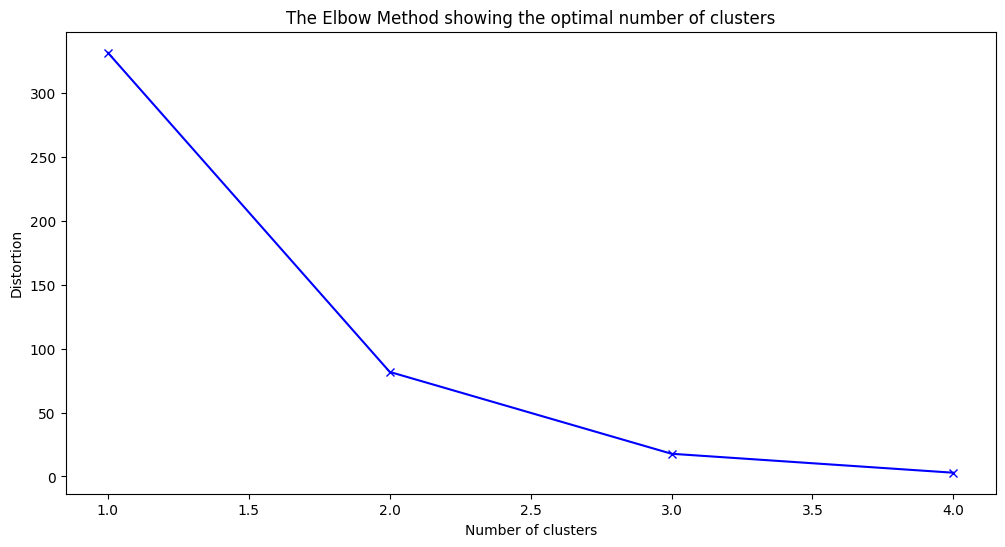

In [225]:
#plot elbow method graph
plt.figure(figsize=(12, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()

In [226]:
#K-Means clustering after seeing 3 clusters is a good amount
kmeans = KMeans(n_clusters=3, random_state=0).fit(geo_price_data[['latitude', 'longitude']])

/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [227]:
#label cluster to the geo_price_data data frame
geo_price_data['cluster'] = kmeans.labels_

In [228]:
#average price of each cluster calculations
geo_price_data['avg_price_per_cluster'] = geo_price_data.groupby('cluster')['usdprice'].transform('mean')

In [229]:
#see how many data points are in each cluster
geo_price_data['data_points_per_cluster'] = geo_price_data.groupby('cluster')['usdprice'].transform('count')

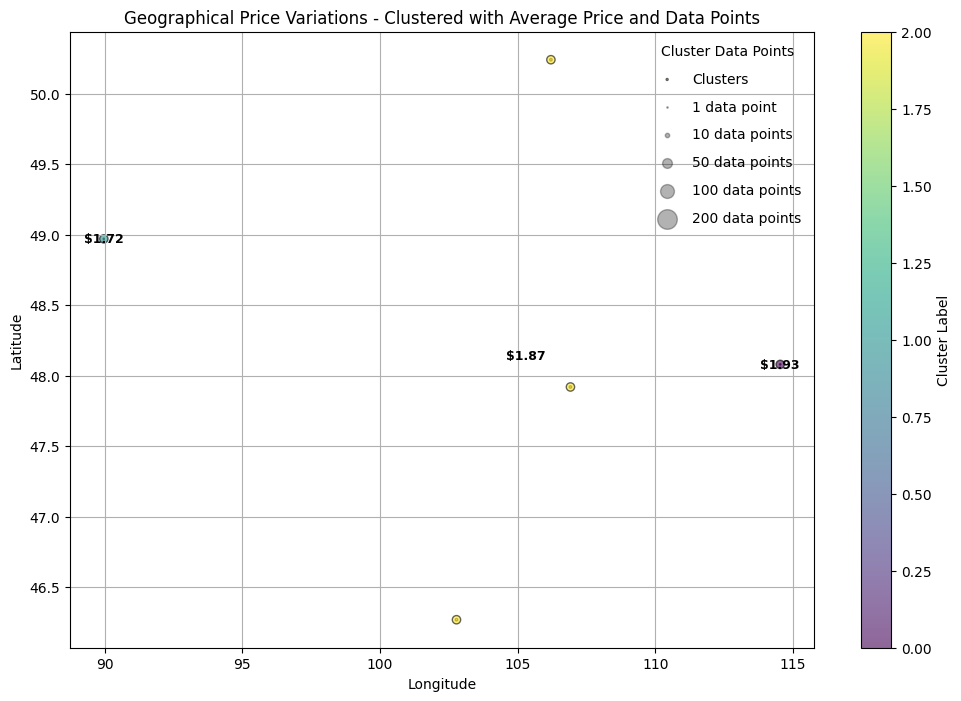

In [230]:
#plot the scatter plot
plt.figure(figsize=(12, 8))
#adjust the sizing and color of each point to match the number of data points in a cluster
scatter = plt.scatter(geo_price_data['longitude'], geo_price_data['latitude'], 
                      s=geo_price_data['data_points_per_cluster'], # This sets the size of the point
                      c=geo_price_data['cluster'], # This sets the color of the point
                      cmap='viridis', alpha=0.6, edgecolor='k', label='Clusters')

#legend for different sizes
for size in [1, 10, 50, 100, 200]:
    plt.scatter([], [], c='k', alpha=0.3, s=size,
                label=f'{size} data points' if size > 1 else f'{size} data point')
#plot average price of each cluster near the actual cluster
for i, cluster_center in enumerate(kmeans.cluster_centers_):
    plt.text(cluster_center[1], cluster_center[0], 
             f'${geo_price_data[geo_price_data["cluster"] == i]["avg_price_per_cluster"].iloc[0]:.2f}',
             fontsize=9, weight='bold', ha='center', va='center', color='black')
scatter = plt.scatter(geo_price_data['longitude'], geo_price_data['latitude'], 
                      c=geo_price_data['cluster'], #series of cluster labels
                      cmap='viridis', #colormap
                      alpha=0.6, edgecolor='k')
#graph's labels
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Cluster Data Points')
plt.colorbar(scatter, label='Cluster Label')
plt.title('Geographical Price Variations - Clustered with Average Price and Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [231]:
#print the first rows of the clustered data and cluster centers
print(geo_price_data.head())
print("Cluster centers:")
print(kmeans.cluster_centers_)

   latitude  longitude  usdprice  cluster  avg_price_per_cluster  \
0     46.27     102.78  1.953720        2               1.874731   
1     47.92     106.92  1.852149        2               1.874731   
2     48.08     114.54  1.928651        0               1.928651   
3     48.97      89.97  1.722257        1               1.722257   
4     50.24     106.21  1.818325        2               1.874731   

   data_points_per_cluster  
0                        3  
1                        3  
2                        1  
3                        1  
4                        3  
Cluster centers:
[[ 48.08       114.54      ]
 [ 48.97        89.97      ]
 [ 48.14333333 105.30333333]]


This dataset does not have enough geographical locations to implement clustering like KMeans. In such a small dataset, each location practically becomes its own cluster. So, a different approach: visualize a map of the geographical price distribution. 

In [232]:
import folium

In [233]:
#base map
map = folium.Map(location=[geo_price_data['latitude'].mean(), geo_price_data['longitude'].mean()], zoom_start=5)

In [234]:
#markers for the map; average price, pin, location
for idx, row in geo_price_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Average Price: ${row['usdprice']:.2f} USD",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map)

In [235]:
map.save("geo_price_map.html")
"geo_price_map.html"

'geo_price_map.html'

The visualized map will be shown in the report.

The third section will forecast future prices of meat (beef) using LSTM model.

In [236]:
#filter dataset for 'Meat (beef)'
beef_data = data[data['commodity'] == 'Meat (beef)']

In [237]:
#aggregate prices by date w/ grouby
beef_prices = beef_data.groupby('date')['usdprice'].mean()

In [238]:
#resample data to have same intervals (monthly)
beef_prices = beef_prices.resample('M').mean()

In [239]:
#display first few rows of time series
beef_prices.head()

date
2007-01-31    2.0005
2007-02-28    2.2196
2007-03-31    2.2915
2007-04-30    2.4440
2007-05-31    2.4953
Freq: M, Name: usdprice, dtype: float64

In [240]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [241]:
mean_value = beef_prices.mean()

In [242]:
#fill NaNs with the mean value
data_filled = beef_prices.fillna(mean_value)

In [243]:
#reapply scaling
scaler = MinMaxScaler(feature_range=(0, 1))
#reshape data to a 2D array where the 2nd dimension is 1
scaled_data = scaler.fit_transform(data_filled.values.reshape(-1, 1))

In [244]:
#recreate datasets for LSTM model
X, Y = create_dataset(scaled_data, time_step)
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = Y[0:train_size], Y[train_size:len(Y)]

In [245]:
#check again for NaNs
print("NaNs in scaled_data after processing:", np.isnan(scaled_data).any())
print("NaNs in X_test after processing:", np.isnan(X_test).any())
print("NaNs in y_test after processing:", np.isnan(y_test).any())

NaNs in scaled_data after processing: False
NaNs in X_test after processing: False
NaNs in y_test after processing: False


In [246]:
#normalizing the data (old one)
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = scaler.fit_transform(np.array(beef_prices).reshape(-1,1))

In [247]:
#create a dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [248]:
#define the time step
time_step = 12
#print("NaNs in scaled_data:", np.isnan(scaled_data).any())

X, Y = create_dataset(scaled_data, time_step)

#split the data into training and testing sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = Y[0:train_size], Y[train_size:len(Y)]

In [249]:
#check for NaNs in X_test and y_test
#print("NaNs in X_test:", np.isnan(X_test).any())
#print("NaNs in y_test:", np.isnan(y_test).any())

In [250]:
#reshape input to [samples, time steps, features] for LSTM to run properly
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

X_train.shape, X_test.shape

((115, 12, 1), (57, 12, 1))

In [251]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [252]:
#building LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(12,1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

2024-01-17 17:46:17.593390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-17 17:46:17.597093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-17 17:46:17.601118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [253]:
#model compiling
model.compile(optimizer='adam', loss='mean_squared_error')

In [254]:
#model training
model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1)

Epoch 1/10


2024-01-17 17:46:18.700279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-17 17:46:18.703829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-17 17:46:18.705848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 7s 25ms/step - loss: 0.1633
Epoch 2/10
2/2 [==============================] - 0s 51ms/step - loss: 0.0822
Epoch 3/10
2/2 [==============================] - 0s 37ms/step - loss: 0.0393
Epoch 4/10
2/2 [==============================] - 0s 17ms/step - loss: 0.0332
Epoch 5/10
2/2 [==============================] - 0s 32ms/step - loss: 0.0491
Epoch 6/10
2/2 [==============================] - 0s 70ms/step - loss: 0.0430
Epoch 7/10
2/2 [==============================] - 0s 37ms/step - loss: 0.0317
Epoch 8/10
2/2 [==============================] - 0s 30ms/step - loss: 0.0287
Epoch 9/10
2/2 [==============================] - 0s 49ms/step - loss: 0.0311
Epoch 10/10
2/2 [==============================] - 0s 30ms/step - loss: 0.0337


In [255]:
def forecast(model, scaled_data, time_step, number_of_future_months=12):
    predictions = []
    last_data = scaled_data[-time_step:]
    current_batch = last_data.reshape(1, time_step, 1)
    
    print("Starting forecast...")

    for i in range(number_of_future_months):
        #prediction 1 time step ahead ([0] to get the scalar value)
        current_pred = model.predict(current_batch)[0]
        
        #print prediction
        print(f"Prediction {i+1}: {current_pred}")
        
        #store prediction
        predictions.append(current_pred) 
        
        #update batch to include new prediction
        current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)
    
    print("Forecast complete.")
    return predictions

future_months = 12

#making sure model and scaled_data are properly defined before calling it
forecasted_scaled_values = forecast(model, scaled_data, time_step, future_months)
print("Scaled Predictions:")
print(forecasted_scaled_values)

#converting scaled predictions back to original scale
forecasted_values = scaler.inverse_transform(np.array(forecasted_scaled_values).reshape(-1, 1))
print("Real-World Predictions:")
print(forecasted_values)

Starting forecast...


2024-01-17 17:46:28.372232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-01-17 17:46:28.374531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-01-17 17:46:28.376737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 2s 2s/step
Prediction 1: [0.43670577]
1/1 [==============================] - 0s 36ms/step
Prediction 2: [0.43100902]
1/1 [==============================] - 0s 32ms/step
Prediction 3: [0.42366344]
1/1 [==============================] - 0s 32ms/step
Prediction 4: [0.41652602]
1/1 [==============================] - 0s 83ms/step
Prediction 5: [0.40926522]
1/1 [==============================] - 0s 42ms/step
Prediction 6: [0.4000052]
1/1 [==============================] - 0s 56ms/step
Prediction 7: [0.39069417]
1/1 [==============================] - 0s 29ms/step
Prediction 8: [0.38109836]
1/1 [==============================] - 0s 40ms/step
Prediction 9: [0.37060842]
1/1 [==============================] - 0s 67ms/step
Prediction 10: [0.360129]
1/1 [==============================] - 0s 55ms/step
Prediction 11: [0.35010713]
1/1 [==============================] - 0s 52ms/step
Prediction 12: [0.3400337]
Forecast complete.
Scaled Predictions:
[array([0.436705

In [256]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [257]:
#y_test are true values
true_values = scaler.inverse_transform(y_test.reshape(-1, 1))
#model.predict(X_test) are predicted values
predicted_values = scaler.inverse_transform(model.predict(X_test))

2/2 [==============================] - 0s 8ms/step


In [258]:
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 0.5010675009268586


In [259]:
mae = mean_absolute_error(true_values, predicted_values)
print('Mean Absolute Error:', mae)

Mean Absolute Error: 0.40439642568220174


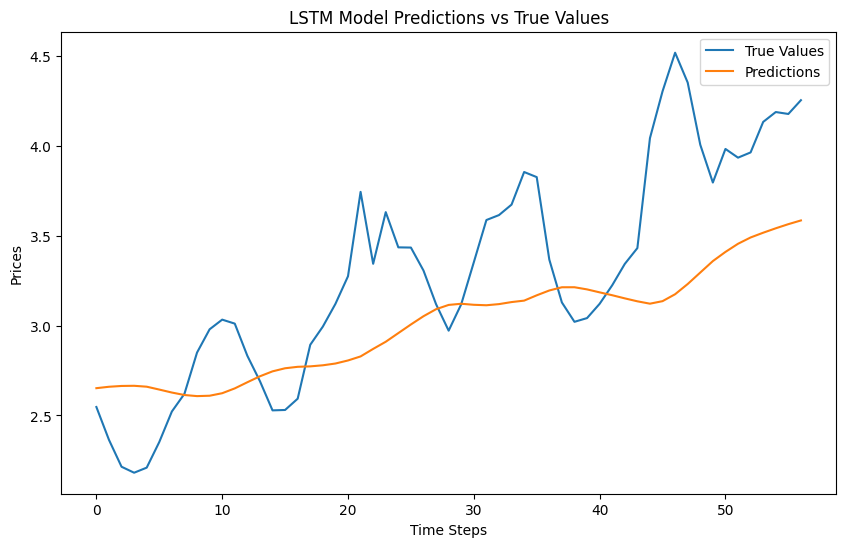

In [260]:
#plot results
plt.figure(figsize=(10, 6))
plt.plot(true_values, label='True Values')
plt.plot(predicted_values, label='Predictions')
plt.title('LSTM Model Predictions vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Prices')
plt.legend()
plt.show()

This is the baseline model of future forecasting

In [261]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [262]:
#load dataset
file_path = 'wfp_food_prices_mng.csv'
data = pd.read_csv(file_path)

In [263]:
#just to make sure 'usdprice' is numeric and handle missing values
data['usdprice'] = pd.to_numeric(data['usdprice'], errors='coerce')
data.dropna(subset=['usdprice'], inplace=True)

In [264]:
#data for only 'Meat (beef)'
beef_data = data[data['commodity'] == 'Meat (beef)'].copy()

In [265]:
# Convert 'date' to datetime and set it as index
beef_data['date'] = pd.to_datetime(beef_data['date'])
beef_data.set_index('date', inplace=True)

In [266]:
#resample the data to monthly frequency and average the prices
monthly_beef_prices = monthly_beef_prices.asfreq('M')

In [267]:
#get rid of any NaN values from resampled data
monthly_beef_prices.dropna(inplace=True)

/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


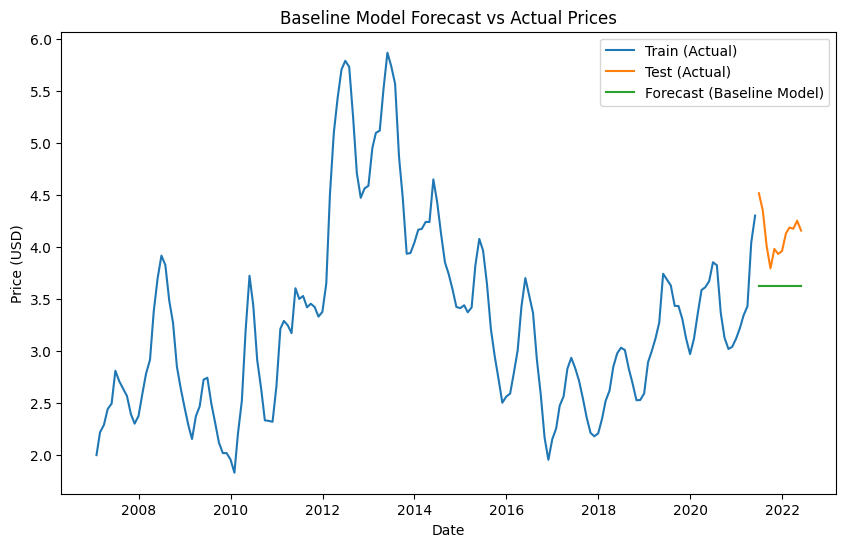

RMSE: 0.534461699982705


In [268]:
#to make sure enough data is used for training and testing (2 yrs)
if len(monthly_beef_prices) >= 24: 
    #split data into training and testing datasets
    train = monthly_beef_prices.iloc[:-12]
    test = monthly_beef_prices.iloc[-12:]

    #fit the model on training data
    model = SimpleExpSmoothing(train).fit(smoothing_level=0.2, optimized=False)

    #forecast for next 12 months
    forecast = model.forecast(12)

    #calculate root mean squared error
    rmse = mean_squared_error(test, forecast, squared=False)

    forecast.index = test.index

    #plot results
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Train (Actual)')
    plt.plot(test.index, test, label='Test (Actual)')
    plt.plot(forecast.index, forecast, label='Forecast (Baseline Model)')
    plt.title('Baseline Model Forecast vs Actual Prices')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

    
    print(f"RMSE: {rmse}")
else:
    print("Not enough data for training and testing.")